# MITRE + OWASP Threat Modelling

In this demo, we will use a graph built from MITRE and OWASP data sources to create a list of security requirements ([OWASP ASVS](https://owasp.org/www-project-application-security-verification-standard/)) based on the consequences ([MITRE CAPEC](https://capec.mitre.org/)) we want to avoid.

To run this demo, you need to build the graph, in this repo there is a 'source' folder, in here are three data routines to be run in order:
- 01 acquire_rawdata.py
- 02 process_rawdata.py
- 03 build_graph.py

These download, transform and build into a grpah.

In [1]:
# import libraries we will use
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import mitretools as mt

In [2]:
# simple routine to help with display
def log(items):
    for key in items:
        print(key)

In [3]:
# load the precompiled graph (you will need to build this)
graph = nx.read_graphml(r'data/processed/mitre-data.graphml')
print('nodes:', len(graph.nodes()))
print('edges:', len(graph.edges()))

nodes: 3063
edges: 9896


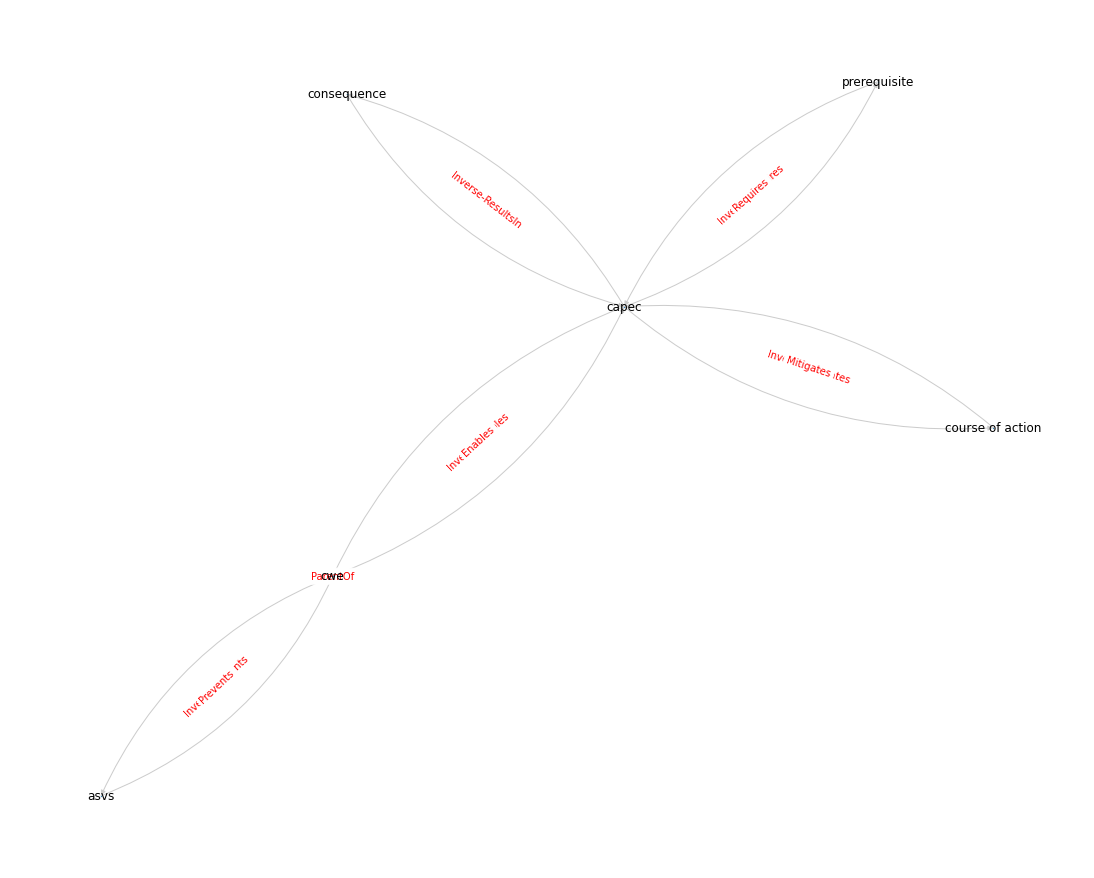

In [4]:
# simplify and draw the node and edge types    
s = mt.simplify_graph(graph)
mt.show_graph(s)

In [5]:
mt.list_nodes(graph, ['consequence', 'asvs', 'cwe', 'capec'], ['kind'])

{'capec': None, 'consequence': None, 'cwe': None, 'asvs': None}

CAPEC references are mapped to Consequences (exploit of a CAPEC ResultsIn a Consequence), Courses of Action (Courses of Action Mitigates exploitation of a CAPEC), CWEs (CWEs are weaknesses which Enables exploitation of a CAPEC). CWEs in turn map to ASVS (ASVS describe how to test if there is a Weakness).

This allows us to build a mapping from Consequences to ASVS.

In [6]:
# list all of the potential consequences
log(mt.list_nodes(graph, ['consequence'], ['group', 'label']))

Confidentiality, Gain Privileges
Access_Control, Gain Privileges
Authorization, Gain Privileges
Availability, Unreliable Execution
Availability, Execute Unauthorized Commands
Confidentiality, Execute Unauthorized Commands
Confidentiality, Read Data
Integrity, Execute Unauthorized Commands
Integrity, Modify Data
Confidentiality, Modify Data
Availability, Resource Consumption
Confidentiality, Bypass Protection Mechanism
Access_Control, Bypass Protection Mechanism
Authorization, Bypass Protection Mechanism
Confidentiality, Other
Authorization, Execute Unauthorized Commands
Accountability, Gain Privileges
Authentication, Gain Privileges
Non-Repudiation, Gain Privileges
Integrity, Gain Privileges
Integrity, Other
Availability, Other
Access_Control, Execute Unauthorized Commands
Integrity, Alter Execution Logic
Integrity, Hide Activities
Integrity, Read Data
Availability, Alter Execution Logic
Confidentiality, Alter Execution Logic
Confidentiality, Hide Activities
Access_Control, Hide Activi

In [7]:
# For this example, we're interested in preventing Authorization issues by Bypassing Protection Mechanisms
# To filter the tree, we set the starting node (label = 'Bypass Protection Mechanism' & group = 'Authorization'),
#    we limit the relationships we will follow, and we set any additional filters... in this case we only want
#    to pass through 'capec' nodes where the likelihood_of_attack is 'High'

requirements = mt.filter_graph(graph, 
                 { 
                     'label': ['Bypass Protection Mechanism'], 
                     'group': ['Authorization'] 
                 }, 
                 { 'relationship': ['Inverse-ResultsIn',
                                    #'ResultsIn', 
                                    'Inverse-Enables', 
                                    #'Enables', 
                                    #'Inverse-Requires',
                                    #'Requires',
                                    'Inverse-Prevents',
                                    #'Prevents',
                                    'Inverse-Mitigates',
                                    #'Mitigates',
                                    'ChildOf',
                                    'ParentOf',
                                     ''
                                   ] },
                [
                    { 'capec' : { 'likelihood_of_attack': 'High' } },
                    { 'asvs' :  { 'level_1': True } }
                ])

In [8]:
# For those consequences, show the CAPEC references they map to
log(mt.list_nodes(requirements, ['capec'], ['label', 'description']))

CAPEC-78, Using Escaped Slashes in Alternate Encoding
CAPEC-244, XSS Targeting URI Placeholders
CAPEC-275, DNS Rebinding
CAPEC-182, Flash Injection
CAPEC-159, Redirect Access to Libraries
CAPEC-87, Forceful Browsing
CAPEC-13, Subverting Environment Variable Values
CAPEC-219, XML Routing Detour Attacks
CAPEC-136, LDAP Injection
CAPEC-199, XSS Using Alternate Syntax
CAPEC-267, Leverage Alternate Encoding
CAPEC-88, OS Command Injection
CAPEC-90, Reflection Attack in Authentication Protocol
CAPEC-180, Exploiting Incorrectly Configured Access Control Security Levels
CAPEC-193, PHP Remote File Inclusion
CAPEC-24, Filter Failure through Buffer Overflow
CAPEC-80, Using UTF-8 Encoding to Bypass Validation Logic


In [9]:
# For those consequences, show the Cources of Action they map to
log(mt.list_nodes(requirements, ['course of action'], ['label', 'description']))

coa-24-1, Pre-design: Use a language or compiler that performs automatic bounds checking.
coa-182-0, Implementation: remove sensitive information such as user name and password in the SWF file.
coa-199-5, Implementation: Perform output validation for all remote content.
coa-126-0, Design: Configure the access control correctly.
coa-193-0, Implementation: Perform input validation for all remote content, including remote and user-generated content
coa-136-1, Use of custom error pages - Attackers can glean information about the nature of queries from descriptive error messages. Input validation must be coupled with customized error pages that inform about an error without disclosing information about the LDAP or application.
coa-24-2, Pre-design through Build: Compiler-based canary mechanisms such as StackGuard, ProPolice and the Microsoft Visual Studio /GS flag. Unless this provides automatic bounds checking, it is not a complete solution.
coa-199-3, Implementation: Ensure all content co

In [10]:
# For those consequences, show the CWEs they map to
log(mt.list_nodes(requirements, ['cwe'], ['label', 'name']))

CWE-675, Duplicate Operations on Resource
CWE-799, Improper Control of Interaction Frequency
CWE-113, Improper Neutralization of CRLF Sequences in HTTP Headers ('HTTP Response Splitting')
CWE-487, Reliance on Package-level Scope
CWE-78, Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')
CWE-107, Struts: Unused Validation Form
CWE-795, Only Filtering Special Elements at a Specified Location
CWE-573, Improper Following of Specification by Caller
CWE-924, Improper Enforcement of Message Integrity During Transmission in a Communication Channel
CWE-580, clone() Method Without super.clone()
CWE-190, Integer Overflow or Wraparound
CWE-562, Return of Stack Variable Address
CWE-697, Incorrect Comparison
CWE-425, Direct Request ('Forced Browsing')
CWE-146, Improper Neutralization of Expression/Command Delimiters
CWE-622, Improper Validation of Function Hook Arguments
CWE-272, Least Privilege Violation
CWE-37, Path Traversal: '/absolute/pathname/here'
CWE-6

In [11]:
# This is what we're after, this is the list of ASVS requirements relevant to the specified consequence
log(mt.list_nodes(requirements, ['asvs'], ['label', 'section_name', 'description']))

ASVS-5.2.3, Validation, Verify that the application sanitizes user input before passing to mail systems to protect against SMTP or IMAP injection.
ASVS-4.1.2, Access, Verify that all user and data attributes and policy information used by access controls cannot be manipulated by end users unless specifically authorized.
ASVS-4.3.2, Access, Verify that directory browsing is disabled unless deliberately desired. Additionally, applications should not allow discovery or disclosure of file or directory metadata, such as Thumbs.db, .DS_Store, .git or .svn folders.
ASVS-8.3.1, Data, Verify that sensitive data is sent to the server in the HTTP message body or headers, and that query string parameters from any HTTP verb do not contain sensitive data.
ASVS-8.3.4, Data, Verify that all sensitive data created and processed by the application has been identified, and ensure that a policy is in place on how to deal with sensitive data. ([C8](https://www.owasp.org/index.php/OWASP_Proactive_Controls#t

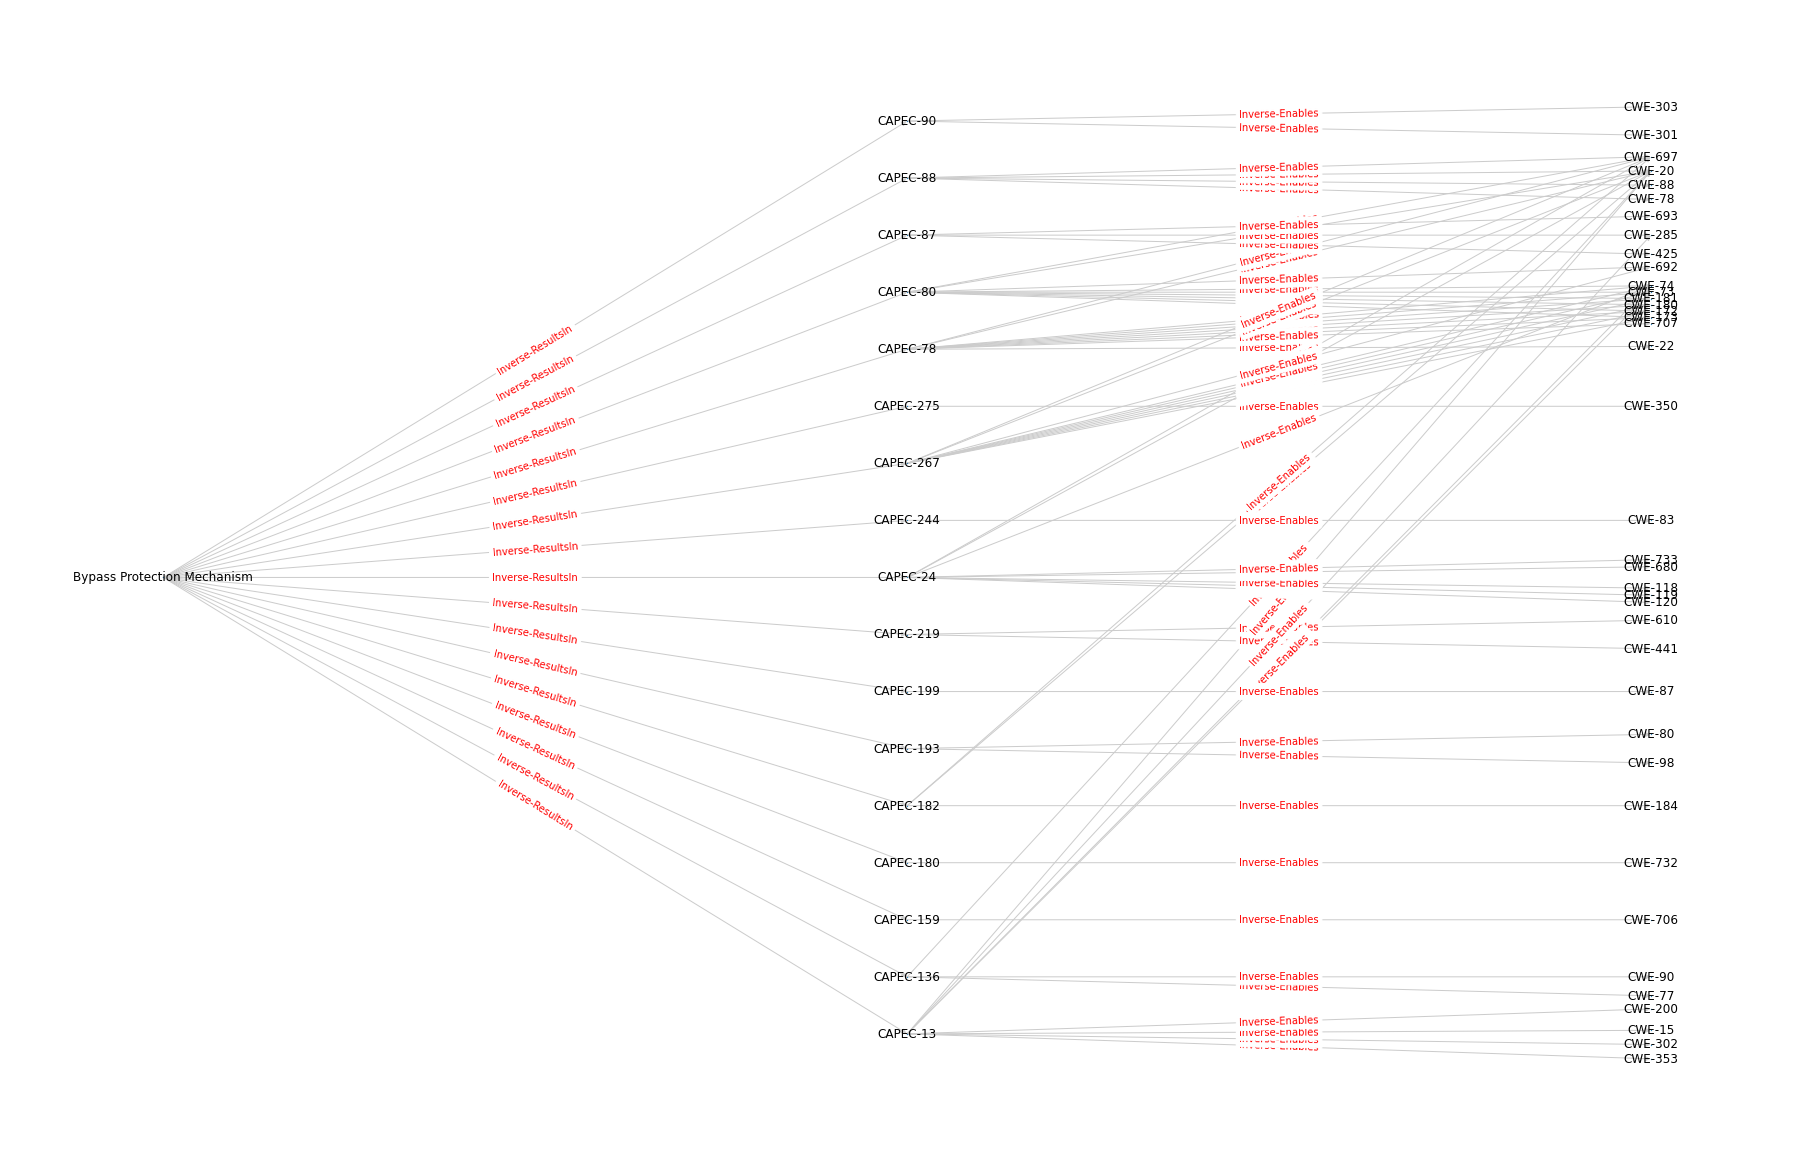

In [15]:
# The actual tree is very messy, this is a simplified, but still quite messy, version of the tree that was walked to get those requirements.

n = mt.filter_graph(graph, 
                 { 
                     'label': ['Bypass Protection Mechanism'], 
                     'group': ['Authorization'] 
                 }, 
                 { 'relationship': ['Inverse-ResultsIn',
                                    #'ResultsIn', 
                                    'Inverse-Enables', 
                                    #'Enables', 
                                    #'Inverse-Requires',
                                    #'Requires',
                                    #'Inverse-Prevents',
                                    #'Prevents',
                                    #'Inverse-Mitigates',
                                    #'Mitigates',
                                    #'ChildOf',
                                    #'ParentOf',
                                     ''
                                   ] },
                [
                    { 'capec' : { 'likelihood_of_attack': 'High' } },
                    { 'asvs' :  { 'level_1': True } }
                ])
mt.show_tree(n)